## Image Morphology Analysis

**Act 1**

_Oct 10 - Oct 16_

### Background

To carry out this analysis, I generated a 3D model of a slightly complicated shape in Blender. Next, I rotated it using blender keyframe and obtained 90 frames of a single revolution (hence 4 deg rotation along axis in each turn). To make sure this is kinda close to real scenario, I rendered a varying background and added noise, shadows, and simulated some shearing in the frames.

In this analysis, I aim to figure out how to obtain morphology axis from the images.

In [58]:
# Get required stuff here

%matplotlib inline

import skimage
import skimage.io
import skimage.morphology
import skimage.filters
import skimage.color
import skimage.segmentation
import skimage.util
import skimage.util.colormap

import matplotlib.pyplot as plt
import numpy as np
import os

from collections import namedtuple

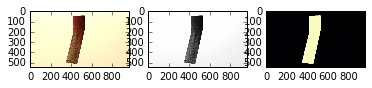

In [6]:
# We're working with a fake stem image I created in Blender.

img_stem = skimage.io.imread('./tmp/fake_stem/0024.png')

# Get a grey-scaled image for further stuff, also get a thresholded binary image.

img_stem_grey = skimage.color.rgb2grey(img_stem)
img_stem_bin = img_stem_grey < skimage.filters.threshold_mean(img_stem_grey)

plt.figure(1)
plt.subplot(131)
plt.imshow(img_stem)
plt.subplot(132)
plt.imshow(img_stem_grey, cmap=plt.cm.gray)
plt.subplot(133)
plt.imshow(img_stem_bin, cmap=plt.cm.magma)

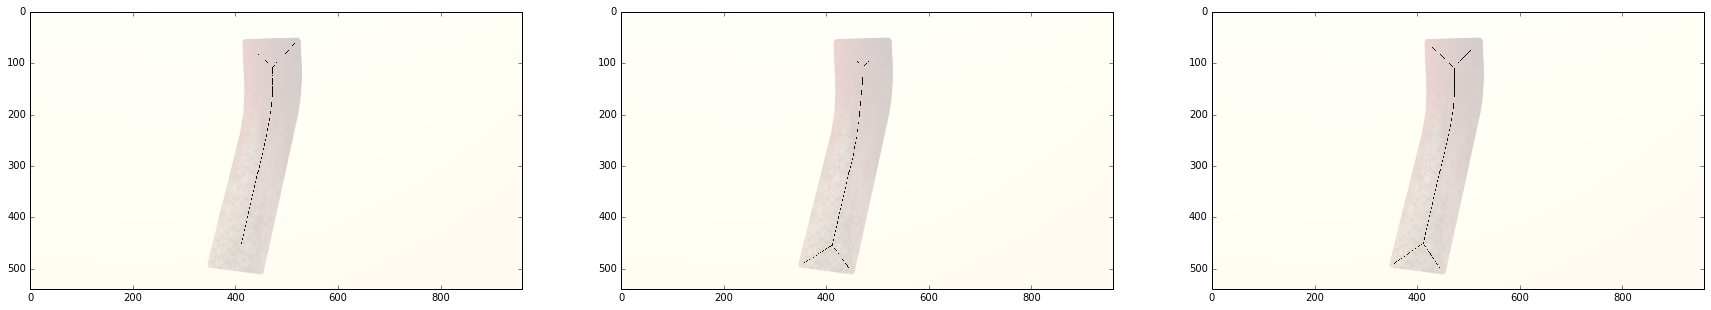

In [24]:
# Now we have a pretty good starting point to use the morphology measures.

medial = skimage.morphology.medial_axis(img_stem_bin)

skeleton = skimage.morphology.skeletonize(img_stem_bin)

thinning = skimage.morphology.thin(img_stem_bin)

plt.figure(2, dpi=80, figsize=(30, 30))
plt.subplot(131)
plt.imshow(img_stem)
plt.imshow(medial, cmap=plt.cm.binary, interpolation='nearest', alpha=0.8)
plt.subplot(132)
plt.imshow(img_stem)
plt.imshow(skeleton, cmap=plt.cm.binary, interpolation='nearest', alpha=0.8)
plt.subplot(133)
plt.imshow(img_stem)
plt.imshow(thinning, cmap=plt.cm.binary, interpolation='nearest', alpha=0.8)


# Thinning seems to be producing the best result. Trying that on other images next.

In [59]:
# Now is a good time to define some helper utils
root_images = namedtuple('RootImages', ['root', 'grey', 'bin', 'name'])

def get_image(path):
  '''Return tuple of pre-processed image.'''
  root = skimage.io.imread(path)
  grey = skimage.color.rgb2gray(root)
  threshold = skimage.filters.threshold_mean(grey)
  binary = grey < threshold
  return root_images(root, grey, binary, os.path.basename(path))

def access_morphology(img):
  thin = skimage.morphology.thin(img.bin)
  medial = skimage.morphology.medial_axis(img.bin)
  
  plt.figure(figsize=(30, 10))
  plt.subplot(221)
  plt.title('Root Image')
  plt.imshow(img.root)
  plt.subplot(222)
  plt.title('Binary Image')
  plt.imshow(img.bin, cmap=plt.cm.binary)
  plt.subplot(223)
  plt.title('Morphology: Thinning')
  plt.imshow(img.root)
  plt.imshow(thin, cmap=plt.cm.binary, alpha=0.8)
  plt.subplot(224)
  plt.title('Morphology: Medial Axis')
  plt.imshow(img.root)
  plt.imshow(medial, cmap=plt.cm.binary, alpha=0.8)

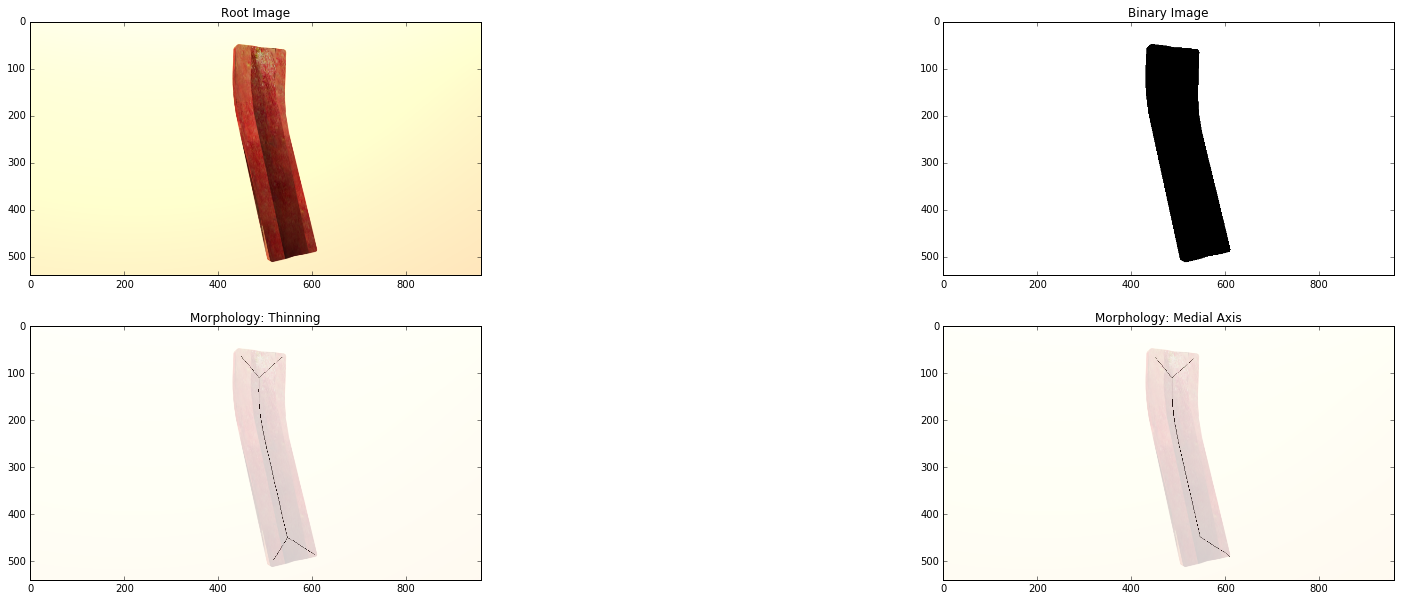

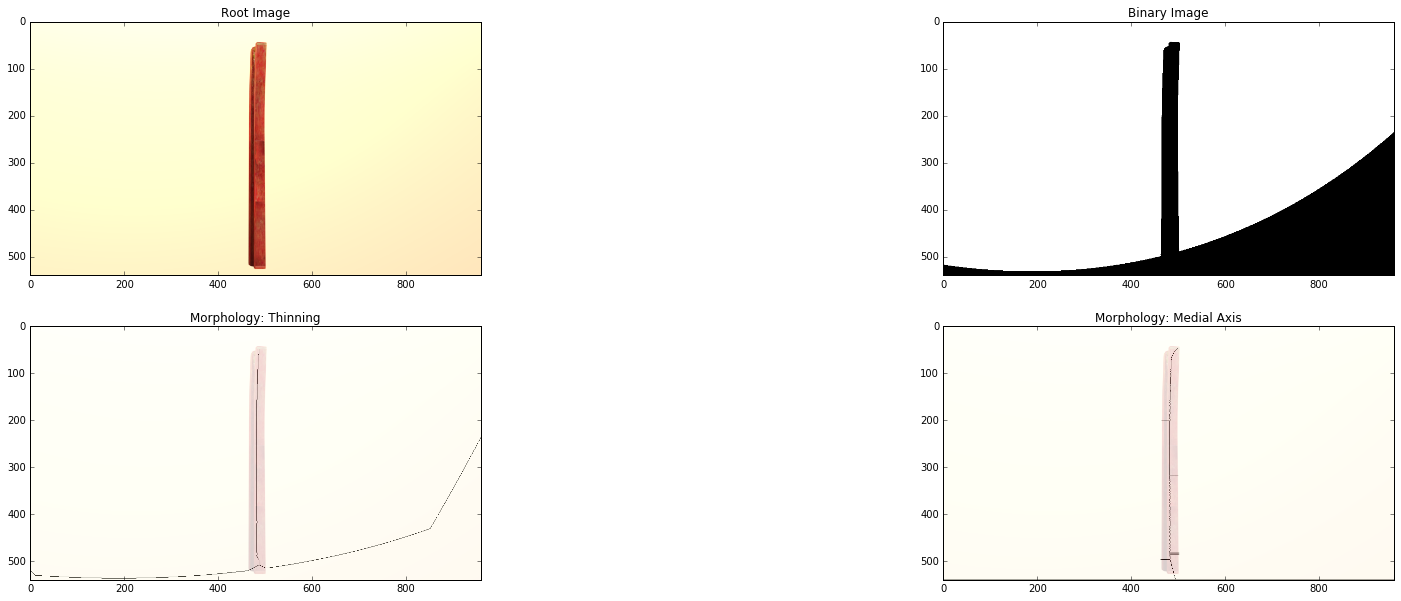

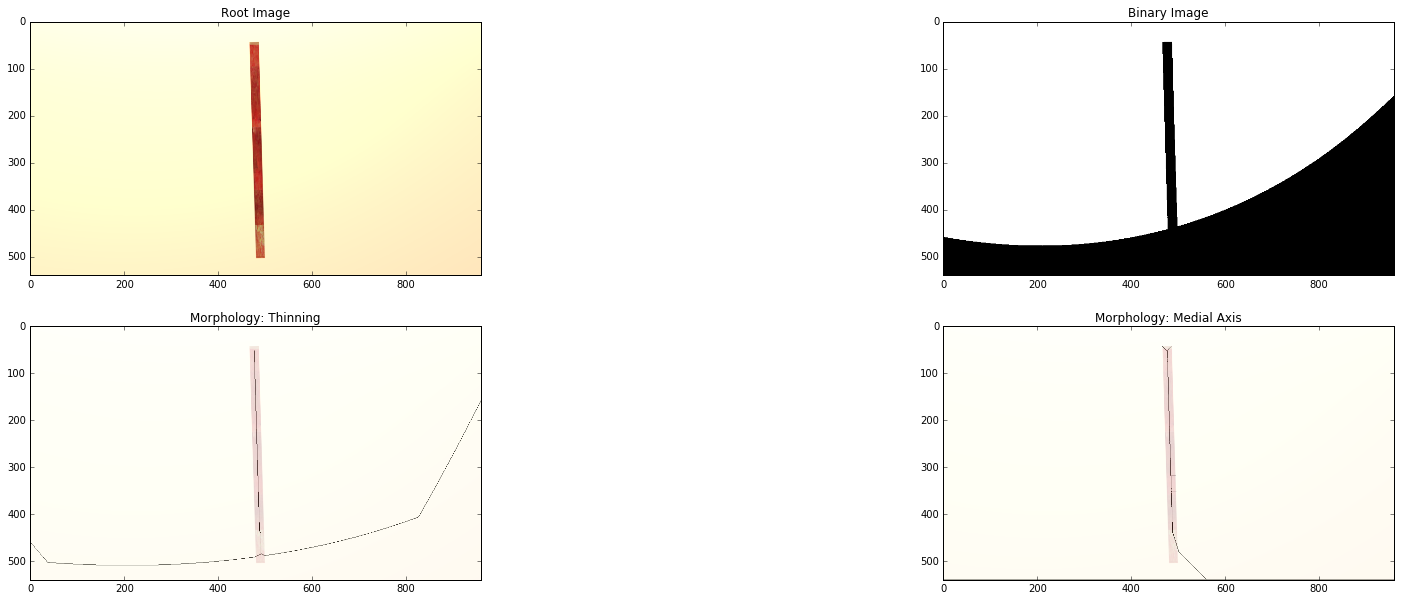

In [60]:
access_morphology(get_image('./tmp/fake_stem/0072.png'))
access_morphology(get_image('./tmp/fake_stem/0047.png'))
access_morphology(get_image('./tmp/fake_stem/0090.png'))

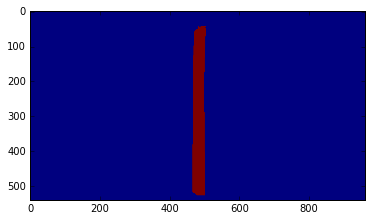

In [42]:
# Thresholding needs a little bit more work...
# Presumably, the "mean" gets lower when there's little image content.
# We need a better thresholding method.

# However, the "thinning" morphology seems to work VERY well.

# Let's move with frame47 above.
frame47 = get_image('./tmp/fake_stem/0047.png')

otsu_i = skimage.filters.threshold_otsu(frame47.grey)
plt.imshow(frame47.grey <= otsu_i)

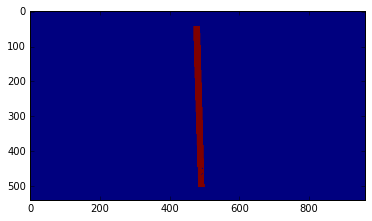

In [43]:
frame90 = get_image('./tmp/fake_stem/0090.png')

otsu_i = skimage.filters.threshold_otsu(frame90.grey)
plt.imshow(frame90.grey <= otsu_i)

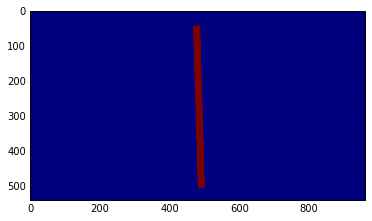

In [45]:
# Otsu method seems to work well. Let's see what's `yen` method like.

frame90 = get_image('./tmp/fake_stem/0090.png')

yen_i = skimage.filters.threshold_yen(frame90.grey)
plt.imshow(frame90.grey <= yen_i)

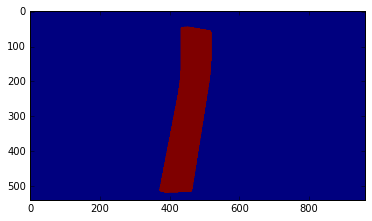

In [47]:
# I notice that the yen method has no "holes" in the lighter region of the element.
# Which is a good thing? I suppose.

# Doing same for a few more image samples to be sure.

frame35 = get_image('./tmp/fake_stem/0035.png')

yen_i = skimage.filters.threshold_yen(frame35.grey)
plt.imshow(frame35.grey <= yen_i)

# Yep.

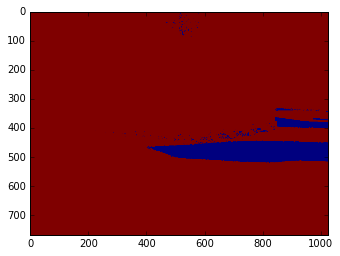

In [48]:
# Trying the same on a non-controlled image -- just to see if it works for that.
stem_im1 = get_image('./tmp/mvi_4835/00061.png')

yen_i = skimage.filters.threshold_yen(stem_im1.grey)
plt.imshow(stem_im1.grey <= yen_i)

# ... nahh.

In [61]:
# Updating `get_image` to use this method.

def get_image_yen(path):
  '''Return tuple of pre-processed image.'''
  root = skimage.io.imread(path)
  grey = skimage.color.rgb2gray(root)
  threshold = skimage.filters.threshold_yen(grey)
  binary = grey < threshold
  return root_images(root, grey, binary, os.path.basename(path))

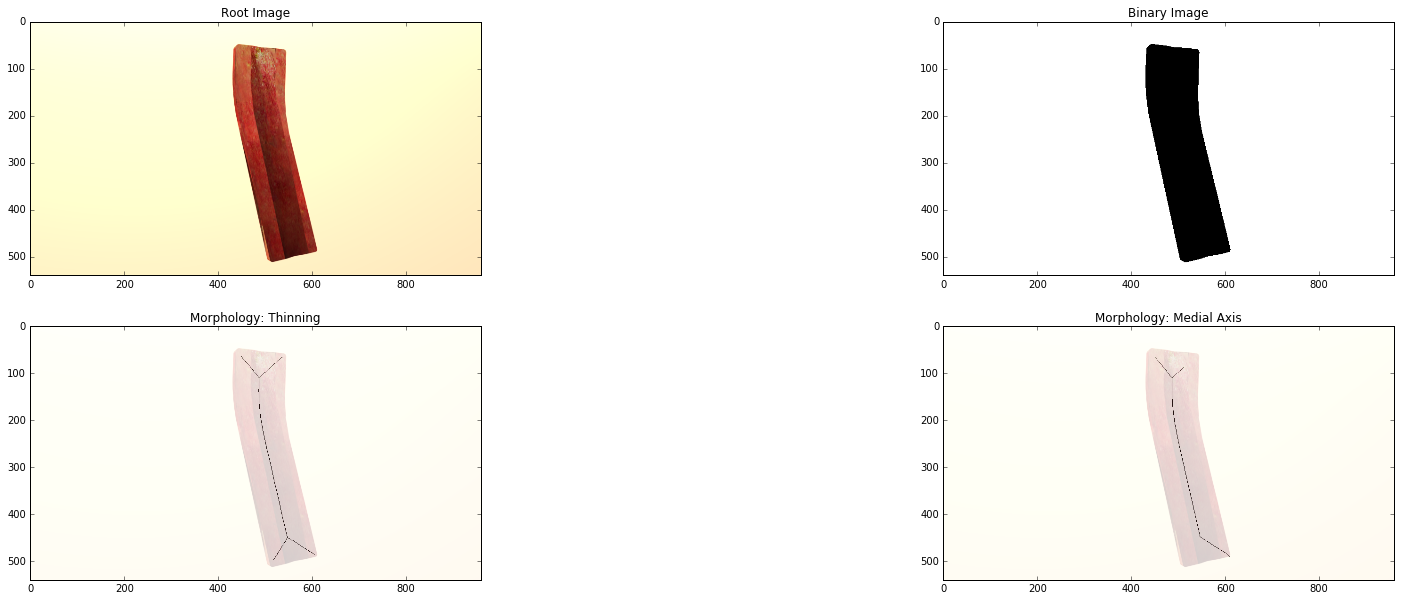

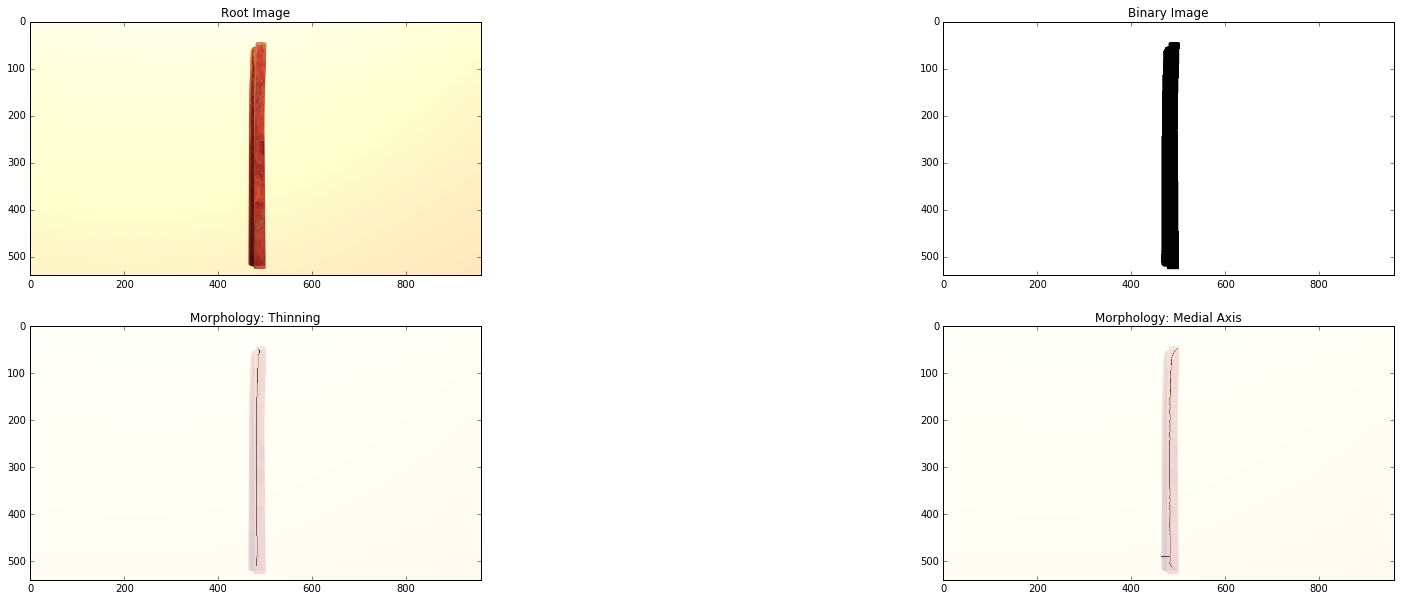

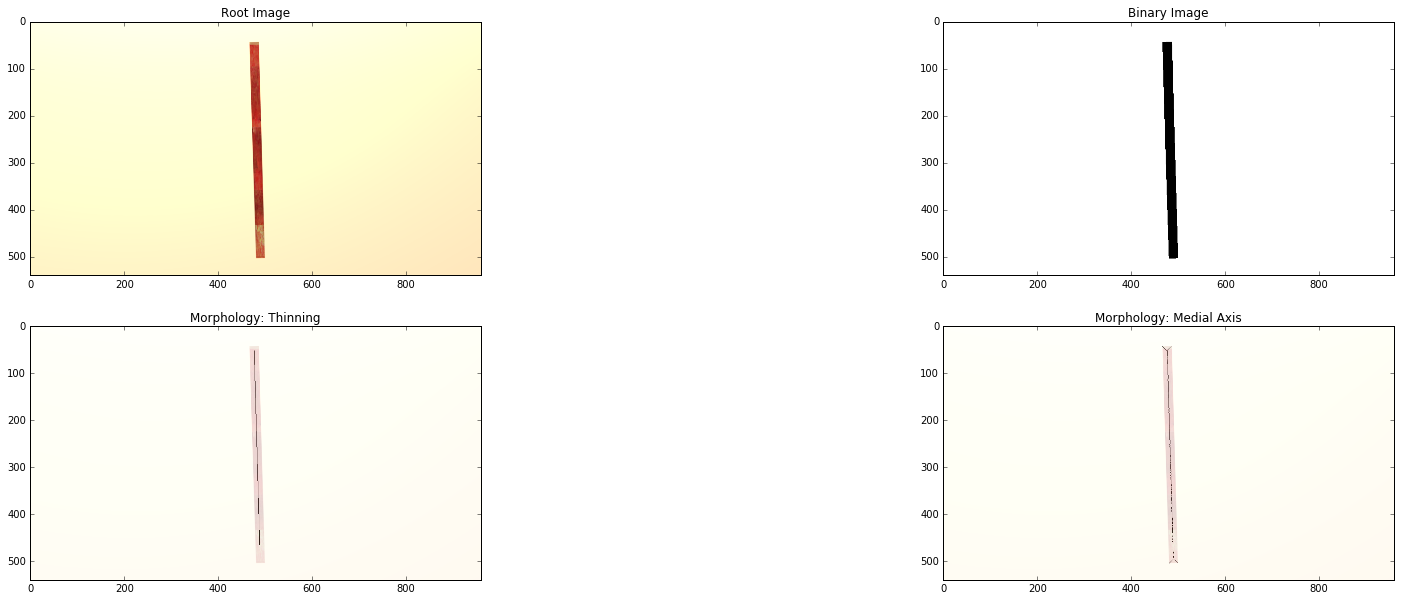

In [62]:
# Run same morphology tests again here.
access_morphology(get_image_yen('./tmp/fake_stem/0072.png'))
access_morphology(get_image_yen('./tmp/fake_stem/0047.png'))
access_morphology(get_image_yen('./tmp/fake_stem/0090.png'))

### Conclusions

* To obtain the morphology of the central object in image, we first require to convert to a binary image.
* Choice of method in the binary image conversion is central.
  * `mean` threshold: Suffers from issues when the area of actual image content is comparatively little.
  * `yen` and `otsu` threshold: Work well for the current usecase.
* Medial Axis morphology does work well consistently.
* Similarly, the Morphological Thinning works well.


**I am going to use `yen` thresholding with `thinning` morphology for further work.**
